# Chapter 2 - Section 2.4, Chapter 3 - Sections 3.3 and 3.4 L-BFGS-B

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import kv, gamma
from scipy.integrate import quad
from scipy.optimize import brentq, minimize
from scipy.stats import norm
from math import exp, sqrt, pi, log, isfinite

## Import target data

In [2]:
file_path = r'/workspaces/VG-Equity-Modelling/target_all.xlsx'

df_raw = pd.read_excel(file_path, engine='openpyxl')

df = df_raw.dropna()

In [3]:
maturities = np.array(df.iloc[:, 0], dtype=float)
print(maturities.shape)

(10,)


In [4]:
moneyness = np.array(df.columns[1:], dtype=float)
print(moneyness.shape)

(17,)


In [5]:
IV_target = np.array(df.iloc[:, 1:], dtype=float)
print(IV_target.shape)

(10, 17)


## Figure 21: Plot target IV vs maturity and moneyness

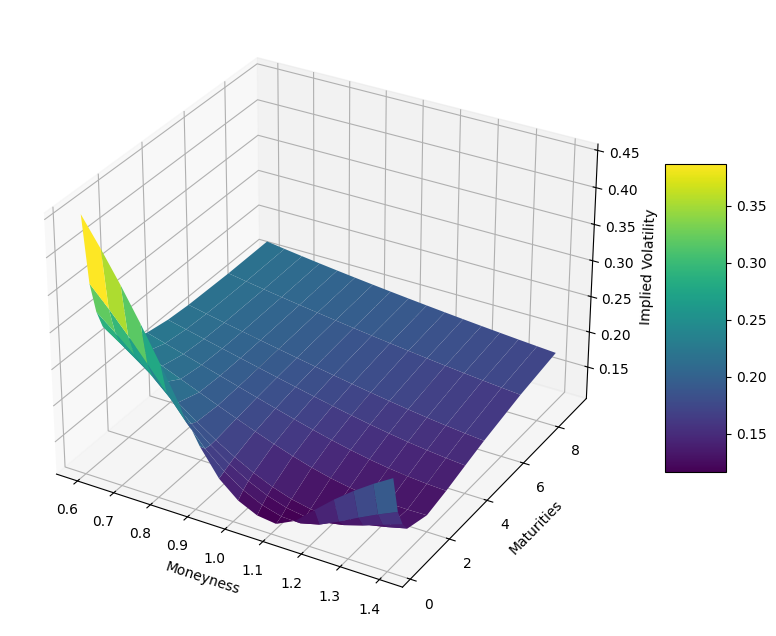

In [6]:
# Create a meshgrid for maturities and moneyness
X, Y = np.meshgrid(moneyness, maturities)

# Plotting the surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, IV_target, cmap='viridis')

# Add labels
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturities')
ax.set_zlabel('Implied Volatility')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()

## Figures 1 to 7 and 15 to 20: Produce the Variance Gamma IV surface using analytical, MC and IFT formulations

The sign which needs to be changed to get the graphs of the incorrect and correct version of the analytical formula discussed in Section 2.4 of the thesis, is found under the european_call_option_price() function. Correct: a = theta / sqrt(sigma ** 2 + nu * theta ** 2 / 2), Incorrect: a = - theta / sqrt(sigma ** 2 + nu * theta ** 2 / 2).

In [7]:
def degenerate_hypergeometric_function(y1, y2, y3, p1, p2):
    def integrand(x):
        return (x ** (y1 - 1) * (1 - x) ** (y3 - y1 - 1) *
                (1 - p1 * x) ** (-y2) * exp(p2 * x))
    result, error = quad(integrand, 0, 1)
    return (gamma(y3) / (gamma(y1) * gamma(y3 - y1))) * result

def Psi(x1, x2, x3):
    try:
        c = abs(x1) * sqrt(2 + x2**2)
        u = x2 / sqrt(2 + x2**2)
        sign_x1 = np.sign(x1)

        term1 = degenerate_hypergeometric_function(x3, 1-x3, 1+x3, (1+u)/2, -sign_x1*c*(1+u))
        term2 = degenerate_hypergeometric_function(1+x3, 1-x3, 2+x3, (1+u)/2, -sign_x1*c*(1+u))

        K_half_plus = kv(x3 + 0.5, c)
        K_half_minus = kv(x3 - 0.5, c)

        psi_value = (c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x3 / (sqrt(2*pi) * gamma(x3) * x3) *
                     K_half_plus * term1 - sign_x1 * c**(x3+0.5) * exp(sign_x1*c) * (1+u)**(1+x3) /
                     (sqrt(2*pi) * gamma(x3) * (1+x3)) * K_half_minus * term2 +
                     sign_x1 * c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x3 /
                     (sqrt(2*pi) * gamma(x3) * x3) * K_half_minus * term1)
    except OverflowError:
        psi_value = np.inf
    return psi_value

def european_call_option_price(S0, K, T, r, theta, sigma, nu):
    try:
        a = theta / sqrt(sigma**2 + nu * theta**2 / 2)
        s = sigma**2 / sqrt(sigma**2 + nu * theta**2 / 2)
        c1 = nu * (a + s)**2 / 2
        c2 = nu * a**2 / 2
        
        d = (log(S0/K) + r*T + (T/nu) * log((1-c1)/(1-c2))) / s
        
        call_price = (S0 * Psi(d * sqrt((1-c1)/nu), (a + s) * sqrt(nu/(1 - c1)), T/nu) -
                      K * exp(-r*T) * Psi(d * sqrt((1-c2)/nu), a * sqrt(nu/(1 - c2)), T/nu))
    except OverflowError:
        call_price = np.inf
    return call_price

def MCeuropean_call_option_price(S_0, K, T, r, theta, sigma, nu, N_paths, type):
    '''A function which calculates the fair
      price of an EU call option based on Monte Carlo simulation.
      Inputs: 
        S_0:        initial asset price
        r:          risk free rate
        sigma:      volatility
        T:          maturity
        N_paths:    number of MC paths simulated
        type:       plain (P), antithetic variates (AV), control variates (CV)
      Outputs:
        The fair price of the B-S EU call option, based on MC simulation.
        '''
    
    # Calculate omega
    omega = 1 / nu * np.log(1 - theta * nu - sigma ** 2 * nu / 2)
    
    # Generate the terminal price directly
    dG_T = np.random.gamma(T / nu, nu, N_paths)
    Z_T = np.random.normal(0, 1, N_paths)

    # Calculate VG paths at maturity
    VG_T = theta * dG_T + sigma * np.sqrt(dG_T) * Z_T
    S_T_paths = S_0 * np.exp((r + omega) * T + VG_T)

    if type == 'P':

      # Plain MC
      MC_payoff = np.maximum(S_T_paths - K, 0)
      return np.exp(-r * T) * np.average(MC_payoff)

    elif type == 'AV':
        # MC with Antithetic Variates Technique
        Z_T_AV = -Z_T  # Antithetic normal random variables
        VG_T_AV = theta * dG_T + sigma * np.sqrt(dG_T) * Z_T_AV
        S_T_paths_AV = S_0 * np.exp((r + omega) * T + VG_T_AV)
        MC_payoff = 0.5 * (np.maximum(S_T_paths - K, 0) + np.maximum(S_T_paths_AV - K, 0))
        return np.exp(-r * T) * np.average(MC_payoff)
    
    elif type == 'CV':
        
        # MC with Control Variates Technique
        X = np.exp(-r * T) * S_T_paths
        Y = np.exp(-r * T) * np.maximum(S_T_paths - K, 0)
        X_est = np.average(X) # Estimator for E(exp(-rT)S_T) = S
        Y_est = np.average(Y) # Estimator for option price
        b = np.sum((X - X_est) * (Y - Y_est)) / np.sum((X - X_est) ** 2)
         # Control variates estimator for option price
        return Y_est - b * (X_est - S_0)
    

def vg_characteristic_function(u, S0, r, T, sigma, theta, nu):
    omega = (1 / nu) * np.log(1 - theta * nu - 0.5 * sigma**2 * nu)
    return np.exp(1j * u * (np.log(S0) + (r + omega) * T)) * (1 - 1j * theta * nu * u + 0.5 * sigma**2 * nu * u**2) ** (-T/nu)

def IFT_european_call_option_price(S0, K, T, r, sigma, theta, nu):
    def integrand2(u):
        # Fourier integrand using the correct characteristic function
        phi_u = vg_characteristic_function(u, S0, r, T, sigma, theta, nu)
        return np.real(np.exp(-1j * u * np.log(K)) * phi_u / (1j * u))
    def integrand1(u):
        # Fourier integrand using the correct characteristic function
        phi_u_i = vg_characteristic_function(u-1j, S0, r, T, sigma, theta, nu)
        phi_i = vg_characteristic_function(-1j, S0, r, T, sigma, theta, nu)
        return np.real(np.exp(-1j * u * np.log(K)) * phi_u_i / (1j * u * phi_i))
    # Numerical integration from 0 to infinity
    int2, error2 = quad(integrand2, 0.000001, 1000)#np.inf)
    int1, error2 = quad(integrand1, 0.000001, 1000)#np.inf)
    P2 = 1/2 + 1/pi * int2
    P1 = 1/2 + 1/pi * int1
    # Final price computation using the Fourier transform method
    call_price = S0 * P1 - K * np.exp(-r * T) * P2
    return call_price

### Figure 1

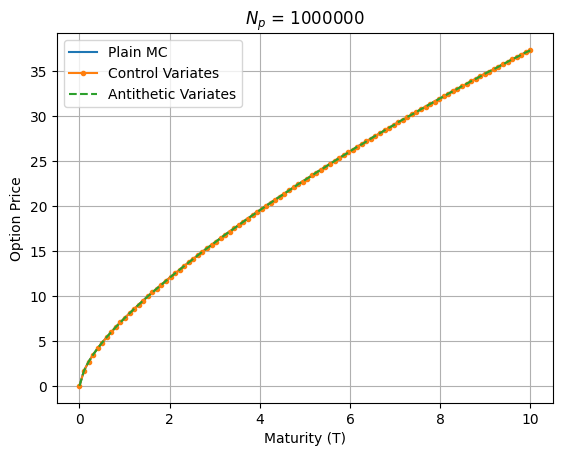

In [8]:
# Parameters
S0 = 100
K = 100
r = 0.042
theta = -0.1436
sigma = 0.1213
nu = 0.1686
time_grid = np.linspace(0.001, 10, 100) 
y_P = np.zeros_like(time_grid)
y_CV = np.zeros_like(time_grid)
y_AV = np.zeros_like(time_grid)
N_paths = 1000000

# Monte Carlo simulation for different maturities and methods
for count, T in enumerate(time_grid):
    y_P[count] = MCeuropean_call_option_price(S0, K, T, r, theta, sigma, nu, N_paths, type='P') 
    y_CV[count] = MCeuropean_call_option_price(S0, K, T, r, theta, sigma, nu, N_paths, type='CV') 
    y_AV[count] = MCeuropean_call_option_price(S0, K, T, r, theta, sigma, nu, N_paths, type='AV') 

# Plot results
plt.title(f'$N_p$ = {N_paths}')
plt.plot(time_grid, y_P, label='Plain MC')
plt.plot(time_grid, y_CV, '.-', label='Control Variates')
plt.plot(time_grid, y_AV, '--', label='Antithetic Variates')
plt.xlabel('Maturity (T)')
plt.ylabel('Option Price')
plt.grid()
plt.legend()
plt.show()

### Figures 2, 3, 4, 5, 6, 7

Depending if you want to plot the correct or incorrect version of the analytical option pricing formula against the MC and IFT option pricing formulas, re-run the cell containing european_call_option_price(), with the desired sign for the parameter a. Then run below cell to produce the graphs, by commenting/uncommenting the lines contining the desired option pricing solutions.

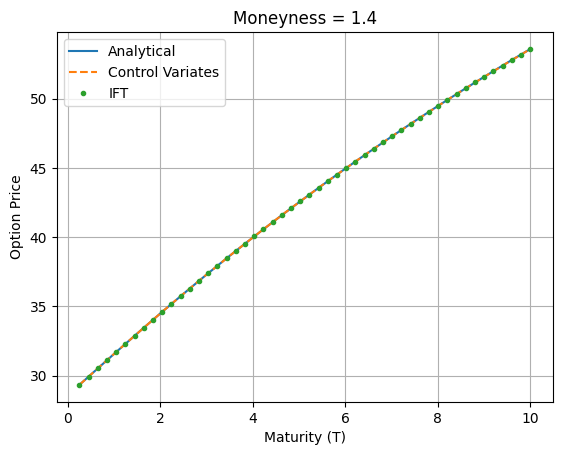

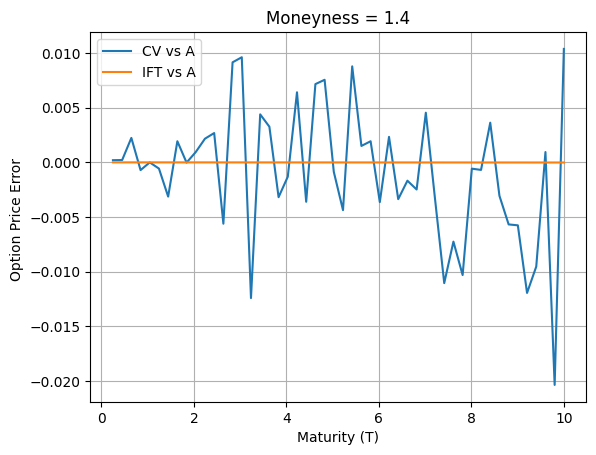

In [9]:
# Parameters
M = 1.4
S0 = 100
K = S0 / M
r = 0.042
theta = -0.1436
sigma = 0.1213
nu = 0.1686
time_grid = np.linspace(0.25, 10, 50)  # Avoid T=0 to prevent division by zero
y_ref = np.zeros_like(time_grid)
y_P = np.zeros_like(time_grid)
y_CV = np.zeros_like(time_grid)
y_AV = np.zeros_like(time_grid)
y_IFT = np.zeros_like(time_grid)

# Monte Carlo simulation for different maturities and methods
for count, T in enumerate(time_grid):
    y_ref[count] = european_call_option_price(S0, K, T, r, theta, sigma, nu)
    y_P[count] = MCeuropean_call_option_price(S0, K, T, r, theta, sigma, nu, N_paths=100000, type='P') 
    y_CV[count] = MCeuropean_call_option_price(S0, K, T, r, theta, sigma, nu, N_paths=100000, type='CV') 
    y_AV[count] = MCeuropean_call_option_price(S0, K, T, r, theta, sigma, nu, N_paths=100000, type='AV') 
    y_IFT[count] = IFT_european_call_option_price(S0, K, T, r, sigma, theta, nu)

# Plot results
plt.plot(time_grid, y_ref, label='Analytical')
# plt.plot(time_grid, y_P, label='Plain MC')
plt.plot(time_grid, y_CV, '--', label='Control Variates')
# plt.plot(time_grid, y_AV, '-.', label='Antithetic Variates')
plt.plot(time_grid, y_IFT, '.', label='IFT')
plt.xlabel('Maturity (T)')
plt.ylabel('Option Price')
plt.legend()
plt.title(f'Moneyness = {M}')
plt.grid()
plt.show()

# Plot results
# plt.plot(time_grid, y_P - y_IFT, label='Plain MC')
plt.plot(time_grid, y_CV - y_ref, label='CV vs A')
plt.plot(time_grid, y_IFT - y_ref, label='IFT vs A')
plt.xlabel('Maturity (T)')
plt.ylabel('Option Price Error ') #[%]
plt.legend()
plt.title(f'Moneyness = {M}')
# plt.title(f'Moneyness = {moneyness}, r = {r}')
plt.grid()
plt.show()

### Figures 15 to 19

0/10 completed
1/10 completed
2/10 completed
3/10 completed
4/10 completed
5/10 completed
6/10 completed
7/10 completed
8/10 completed
9/10 completed


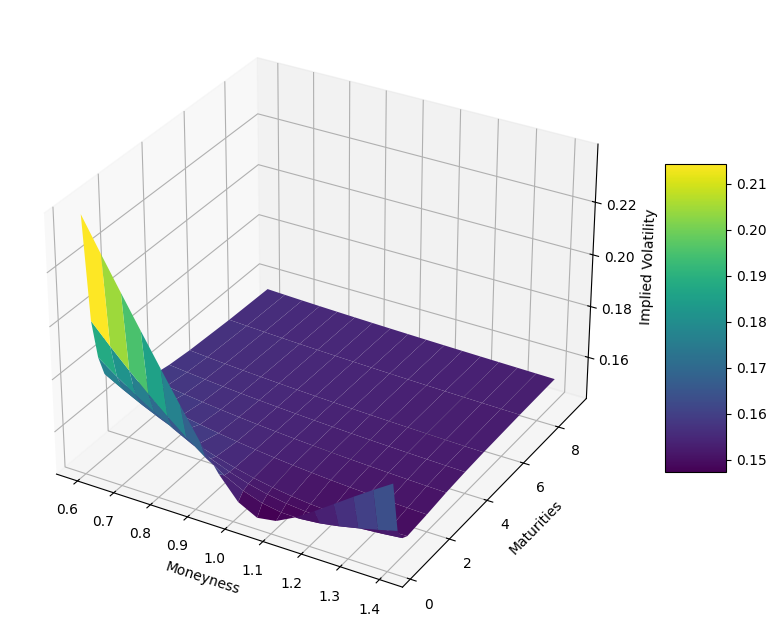

In [10]:
def black_scholes_call(S0, K, T, r, sigma):
    """Price a European call option using the Black-Scholes formula."""
    if T <= 0:
        return max(S0 - K, 0)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility(S0, K, T, r, observed_price):
    """Calculate the implied volatility using the Black-Scholes model."""
    def iv_objective(sigma):
        return black_scholes_call(S0, K, T, r, sigma) - observed_price
    try:
        return brentq(iv_objective, 0.01, 2.0)  # Search between 1% and 200% volatility
    except ValueError:
        return np.nan  # Return NaN if no solution is found

S0 = 100
r = 0.042 #0.042 #-0.3
theta = 0.14 #-0.1436 #-0.4 #0.15
sigma = 0.15 #0.1213 #0.1 #0.12
nu = 0.07 #0.1686 #0.1686

# Calculate the implied volatility surface
implied_vols = np.zeros((len(maturities), len(moneyness)))

for i, T in enumerate(maturities):
    print(f'{i}/{len(maturities)} completed')
    for j, M in enumerate(moneyness):
        K = S0 / M
        market_price = european_call_option_price(S0, K, T, r, theta, sigma, nu)
        implied_vols[i, j] = implied_volatility(S0, K, T, r, market_price)

# Plotting the implied volatility surface
X, Y = np.meshgrid(moneyness, maturities)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, implied_vols, cmap='viridis')

# Add labels
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturities')
ax.set_zlabel('Implied Volatility')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()

### Figure 20

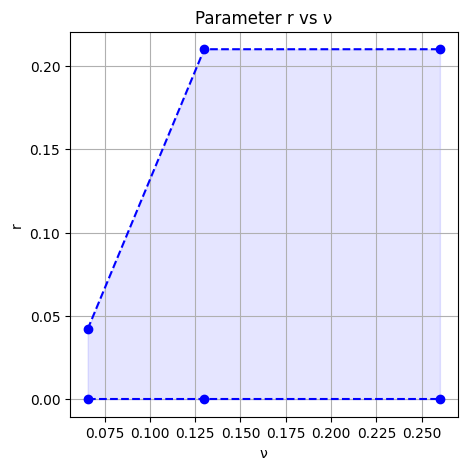

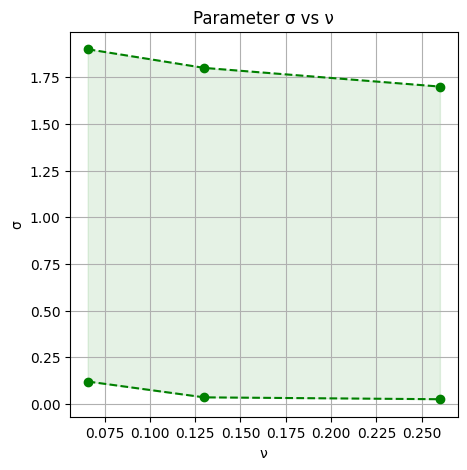

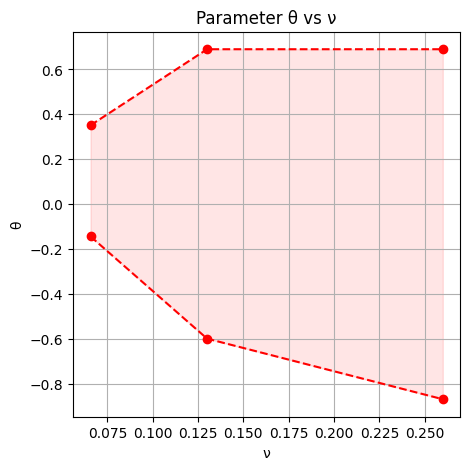

In [227]:
# Define the parameter ranges for different values of ν
nu_values = [0.0657, 0.13, 0.26]

# Corresponding ranges for r, sigma, and theta
r_ranges = [(0, 0.042), (0, 0.21), (0, 0.21)]
sigma_ranges = [(0.1208, 1.9), (0.036, 1.8), (0.026, 1.7)]
theta_ranges = [(-0.1445, 0.351), (-0.6, 0.69), (-0.87, 0.69)]

# Plot r vs ν
plt.figure(figsize=(5, 5))
plt.plot(nu_values, [r[0] for r in r_ranges], marker='o', linestyle='--', color='blue') #, label='r lower bound'
plt.plot(nu_values, [r[1] for r in r_ranges], marker='o', linestyle='--', color='blue') #, label='r upper bound'
plt.fill_between(nu_values, [r[0] for r in r_ranges], [r[1] for r in r_ranges], color='blue', alpha=0.1)
plt.xlabel('ν')
plt.ylabel('r')
plt.title('Parameter r vs ν')
# plt.legend()
plt.grid(True)
plt.show()

# Plot sigma vs ν
plt.figure(figsize=(5, 5))
plt.plot(nu_values, [sigma[0] for sigma in sigma_ranges], marker='o', linestyle='--', color='green') #, label='σ lower bound'
plt.plot(nu_values, [sigma[1] for sigma in sigma_ranges], marker='o', linestyle='--', color='green') #, label='σ upper bound'
plt.fill_between(nu_values, [sigma[0] for sigma in sigma_ranges], [sigma[1] for sigma in sigma_ranges], color='green', alpha=0.1)
plt.xlabel('ν')
plt.ylabel('σ')
plt.title('Parameter σ vs ν')
# plt.legend()
plt.grid(True)
plt.show()

# Plot theta vs ν
plt.figure(figsize=(5, 5))
plt.plot(nu_values, [theta[0] for theta in theta_ranges], marker='o', linestyle='--', color='red') #, label='θ lower bound'
plt.plot(nu_values, [theta[1] for theta in theta_ranges], marker='o', linestyle='--', color='red') #, label='θ upper bound'
plt.fill_between(nu_values, [theta[0] for theta in theta_ranges], [theta[1] for theta in theta_ranges], color='red', alpha=0.1)
plt.xlabel('ν')
plt.ylabel('θ')
plt.title('Parameter θ vs ν')
# plt.legend()
plt.grid(True)
plt.show()


## Figures 22 to 24: Calibration of VG model to target

### Figure 22 - r optimization parameter

Adjust the initial values and boundaries of below algorithm according to Table 1, to get the desired results and graphs

Optimized Parameters:
r: -0.08252104890789184
theta: 0.0394627646329997
sigma: 0.13030540771285212
nu: 2.4545664633909245


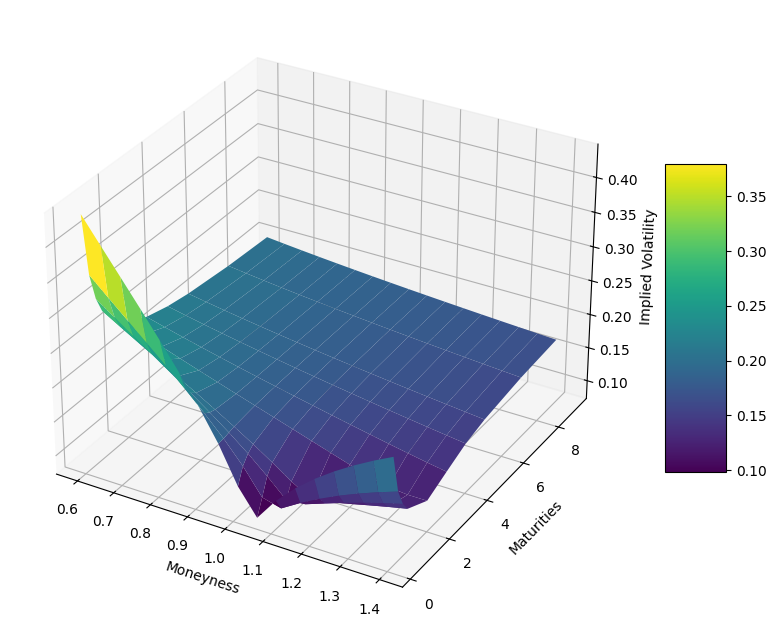

In [141]:
# Fix S0
S0 = 5639.17

# Define RMSE function to minimize
def rmse(params):
    r, theta, sigma, nu = params
    if theta < 1/nu - sigma**2 / 2:
        error = 0
        count = 0
        for i, T in enumerate(maturities):
            for j, M in enumerate(moneyness):
                K = S0 / M
                market_price = european_call_option_price(S0, K, T, r, theta, sigma, nu)
                model_iv = implied_volatility(S0, K, T, r, market_price)
                target_iv = IV_target[i, j]
                if not np.isnan(model_iv) and not np.isnan(target_iv):
                    error += (model_iv - target_iv) ** 2
                    count += 1
        if count == 0:
            return 10000
        else:
            return np.sqrt(error / count)
    else:
        return 10000

# Initial guess for the parameters
initial_guess = [0.01, 0.1436, 0.1213, 0.1681]

# Perform the optimization
result = minimize(rmse, initial_guess, method='L-BFGS-B',
                  bounds=[(-0.1, 0.1), (-2, 2), (0.01, 0.4), (0.06, 4)])

# Extract the optimized parameters
r_opt, theta_opt, sigma_opt, nu_opt = result.x

print(f"Optimized Parameters:\nr: {r_opt}\ntheta: {theta_opt}\nsigma: {sigma_opt}\nnu: {nu_opt}")

# Calculate the implied volatility surface using the optimized parameters
implied_vols_opt = np.zeros((len(maturities), len(moneyness)))

for i, T in enumerate(maturities):
    for j, M in enumerate(moneyness):
        K = S0 / M
        market_price = european_call_option_price(S0, K, T, r_opt, theta_opt, sigma_opt, nu_opt) 
        implied_vols_opt[i, j] = implied_volatility(S0, K, T, r_opt, market_price)

# Plotting the implied volatility surface with optimized parameters
X, Y = np.meshgrid(moneyness, maturities)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, implied_vols_opt, cmap='viridis')

# Add labels
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturities')
ax.set_zlabel('Implied Volatility')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()

In [148]:
params = r_opt, theta_opt, sigma_opt, nu_opt
print(np.round(rmse(params),10))

0.0099141659


In [149]:
params = r_opt, theta_opt, sigma_opt, nu_opt
print(np.round(rmse(params),10))

0.0099141659


In [150]:
print(np.round([r_opt, theta_opt, sigma_opt, nu_opt], 6))

[-0.082521  0.039463  0.130305  2.454566]


In [343]:
print(result)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.011278113362978267
        x: [ 0.000e+00  7.841e-02  1.344e-01  1.534e+00]
      nit: 25
      jac: [ 2.596e-02 -3.473e-05 -2.101e-04  9.465e-05]
     nfev: 250
     njev: 50
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


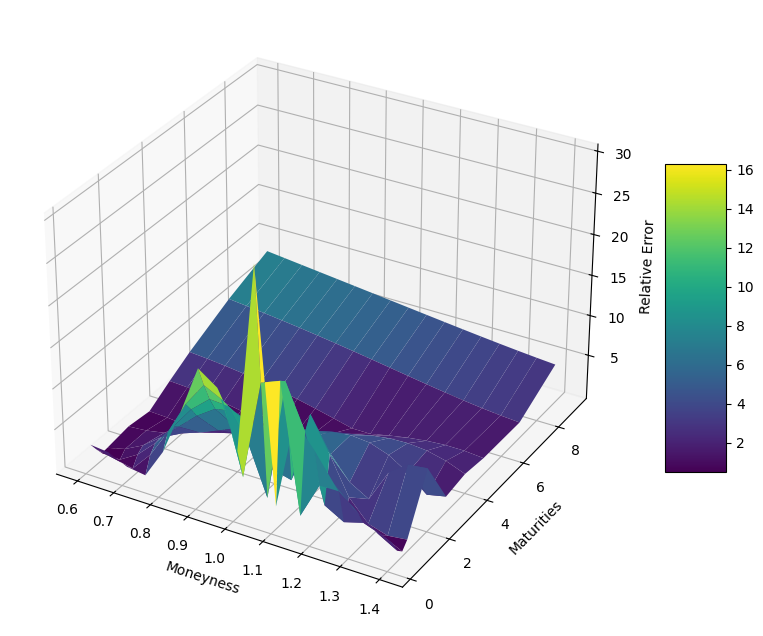

In [147]:
# Calculate the relative error
relative_error = np.abs((implied_vols_opt - IV_target) / IV_target) * 100

# Plotting the relative error surface with swapped axes
X, Y = np.meshgrid(moneyness, maturities)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, relative_error, cmap='viridis')

# Add labels
ax.set_ylabel('Maturities')
ax.set_xlabel('Moneyness')
ax.set_zlabel('Relative Error')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()

### r not an optimization parameter, r = r(T)

#### Figure 23

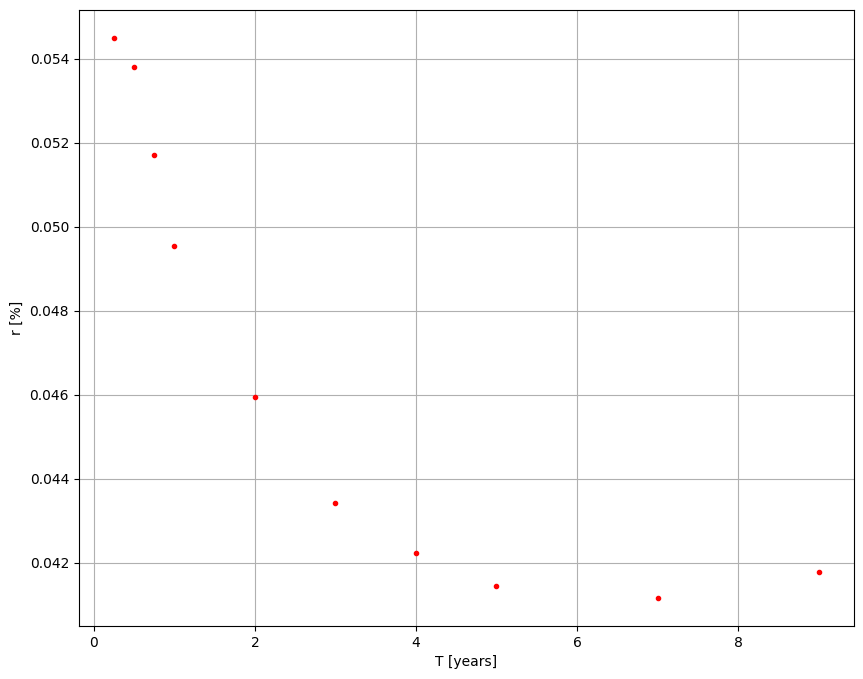

In [37]:

rfr = np.array([5.45, 5.38, 5.17, 4.9541, 4.5955, 4.3423, 4.2219, 4.1448, 4.1164, 4.1769])/100
T_rfr = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 7, 9]

plt.figure(figsize=(10, 8))
plt.plot(T_rfr, rfr, 'r.')
plt.grid()
plt.xlabel('T [years]')
plt.ylabel('r [%]')
plt.show()

#### Figure 24

Adjust the boundaries and initial values of the optimization algorithm according to Table 2, to get the desired solutions.

Optimized Parameters:
theta: 0.10436057027336312
sigma: 0.13490149278817742
nu: 1.2161483243932862


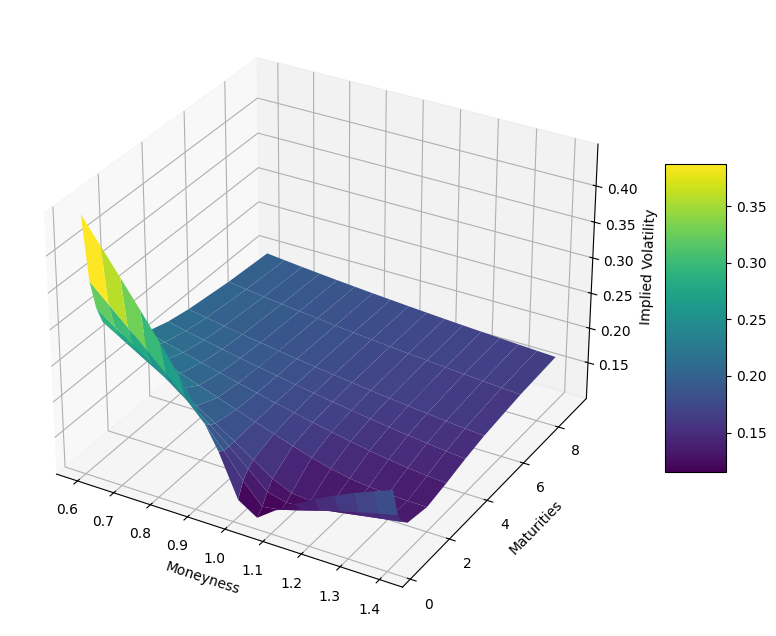

In [151]:
# Fix S0 and r
S0 = 5639.17
rfr = np.array([5.45, 5.38, 5.17, 4.9541, 4.5955, 4.3423, 4.2219, 4.1448, 4.1164, 4.1769])/100

# Define RMSE function to minimize
def rmse(params):
    theta, sigma, nu = params
    if theta < 1/nu - sigma**2 / 2:
        error = 0
        count = 0
        rfr = np.array([5.45, 5.38, 5.17, 4.9541, 4.5955, 4.3423, 4.2219, 4.1448, 4.1164, 4.1769])/100
        for i, T in enumerate(maturities):
            for j, M in enumerate(moneyness):
                K = S0 / M
                r = rfr[i]
                market_price = european_call_option_price(S0, K, T, r, theta, sigma, nu)
                model_iv = implied_volatility(S0, K, T, r, market_price)
                target_iv = IV_target[i, j]
                if not np.isnan(model_iv) and not np.isnan(target_iv):
                    error += (model_iv - target_iv) ** 2
                    count += 1
        if count == 0:
            return 10000
        else:
            return np.sqrt(error / count)
    else:
        return 10000

# Initial guess for the parameters
initial_guess = [0.104365, 0.134885, 1.216146]

# Perform the optimization
result = minimize(rmse, initial_guess, method='L-BFGS-B',
                  bounds=[(-0.5, 0.5), (0.01, 0.4), (0.06, 4)])

# Extract the optimized parameters
theta_opt, sigma_opt, nu_opt = result.x

print(f"Optimized Parameters:\ntheta: {theta_opt}\nsigma: {sigma_opt}\nnu: {nu_opt}")

# Calculate the implied volatility surface using the optimized parameters
implied_vols_opt = np.zeros((len(maturities), len(moneyness)))

for i, T in enumerate(maturities):
    for j, M in enumerate(moneyness):
        K = S0 / M
        r = rfr[i]
        market_price = european_call_option_price(S0, K, T, r, theta_opt, sigma_opt, nu_opt)
        implied_vols_opt[i, j] = implied_volatility(S0, K, T, r, market_price)

# Plotting the implied volatility surface with optimized parameters
X, Y = np.meshgrid(moneyness, maturities)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, implied_vols_opt, cmap='viridis')

# Add labels
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturities')
ax.set_zlabel('Implied Volatility')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()

In [152]:
print(np.round([theta_opt, sigma_opt, nu_opt], 6))

[0.104361 0.134901 1.216148]


In [153]:
params = theta_opt, sigma_opt, nu_opt
print(rmse(params))

0.011696098974681317


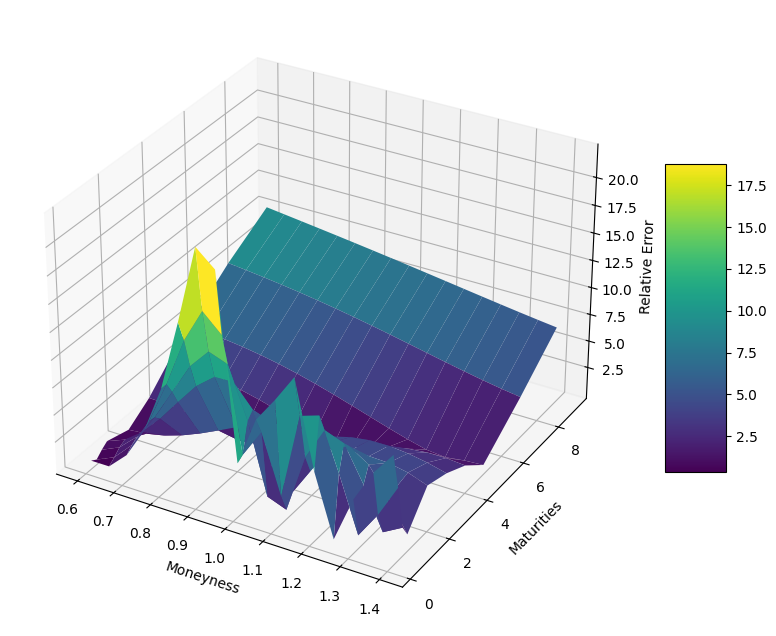

In [156]:
# Calculate the relative error
relative_error = np.abs((implied_vols_opt - IV_target) / IV_target * 100 )

# Plotting the relative error surface with swapped axes
X, Y = np.meshgrid(moneyness, maturities)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, relative_error, cmap='viridis')

# Add labels
ax.set_ylabel('Maturities')
ax.set_xlabel('Moneyness')
ax.set_zlabel('Relative Error')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()